In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem


DATAPATH = "../data"

In [2]:
df = pd.read_csv(os.path.join(DATAPATH, "OSAMasterList.csv"))
df.head()

,OSA_ID,Salt,Batch,Target,Target % activity,SMILES_parent,Img,Name,InChiKey,VendorID/ LabNotebook ID/Other Code,...,CompTox,Lipidmaps,DrugCentral,Carotenoid,Metabolights,Brenda,rhea,chemicalbook,swisslipids,gsrs
0,OSA_000001,NaN,NaN,MurD,79.6,CN1CCN(CC1)c1ccc(cc1)C#N,#NAME?,4-(4-methylpiperazin-1-yl)benzonitrile,ZSDPKKGOSKXEHN-UHFFFAOYSA-N,Z2856434840,...,DTXSID30354088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OSA_000002,NaN,NaN,MurD,128,CN1CCN(CC1)C(=O)NC1=CC=C(F)C=C1,#NAME?,N-(4-fluorophenyl)-4-methylpiperazine-1-carbox...,MDBPFVSVLGYVCQ-UHFFFAOYSA-N,Z2856434944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OSA_000003,NaN,NaN,MurD,NaN,CC(CO)(CO)NC(=O)Nc1ccccc1,#NAME?,"3-(1,3-dihydroxy-2-methylpropan-2-yl)-1-phenyl...",NLGYHTMGWVQQIL-UHFFFAOYSA-N,Z57472297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OSA_000004,NaN,NaN,MurD,72.4,CC(C(Nc1cc(C#N)ccc1)=O)C,#NAME?,N-(3-cyanophenyl)-2-methylpropanamide,JWBISRKEEZGPFB-UHFFFAOYSA-N,Z26548083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OSA_000005,NaN,NaN,MurE,NaN,O=S1(CCN(CC1)Cc2ccc(C)cc2)=O,#NAME?,"4-(4-methylbenzyl)thiomorpholine 1,1-dioxide",PBEMXBVPRZGFNM-UHFFFAOYSA-N,Z2856434929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df[["OSA_ID","Target % activity", "SMILES_parent" ]]
df.rename({"OSA_ID":"ID", "Target % activity":"activity", "SMILES_parent":"SMILES"}, axis=1, inplace=True)

In [4]:
df.dropna(subset=["activity"], inplace=True)

In [5]:
act = df["activity"].tolist()

df["activity"] = df["activity"].apply(lambda x: float(x.split(" &")[0]))


In [6]:
bin_act = []
for i in df["activity"].tolist():
    if i > 20:
        bin = 0
    else:
        bin = 1
    bin_act += [bin]
df["bin_act"]=bin_act

In [7]:
len(df[df["bin_act"]==1])
len(df[df["bin_act"]==0])

51

[flaml.automl: 05-29 19:37:12] {2365} INFO - task = classification
[flaml.automl: 05-29 19:37:12] {2367} INFO - Data split method: stratified
[flaml.automl: 05-29 19:37:12] {2371} INFO - Evaluation method: cv
[flaml.automl: 05-29 19:37:12] {2448} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 05-29 19:37:12] {2561} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 05-29 19:37:12] {2853} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-29 19:37:13] {2984} INFO - Estimated sufficient time budget=15141s. Estimated necessary time budget=349s.
[flaml.automl: 05-29 19:37:13] {3036} INFO -  at 1.5s,	estimator lgbm's best error=0.2975,	best estimator lgbm's best error=0.2975
[flaml.automl: 05-29 19:37:13] {2853} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-29 19:37:14] {3036} INFO -  at 2.2s,	estimator lgbm's best error=0.2975,	best estimator lgbm's best error=0.2975
[flaml.automl: 05-29 

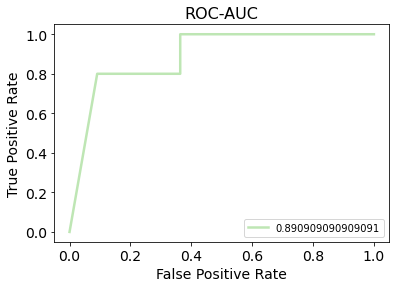

In [13]:
import sys
sys.path.append("..")
from src.lazy_morgan import MorganBinaryClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df["SMILES"], df["bin_act"], test_size=0.2)

mdl = MorganBinaryClassifier()
mdl.fit(X_train, y_train)
y_pred = mdl.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join("../figures", "roc_auto6.png"))

In [18]:
mdl._auroc

0.9333333333333333

In [16]:
y_pred

array([[0.60658935, 0.39341065],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.24868421, 0.75131579],
       [0.82398065, 0.17601935],
       [0.24868421, 0.75131579],
       [0.6478937 , 0.3521063 ],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.82398065, 0.17601935],
       [0.53116883, 0.46883117],
       [0.60029644, 0.39970356],
       [0.82398065, 0.17601935]])